<a href="https://colab.research.google.com/github/shalakagangadhare/Road-traffic-sign/blob/main/Road__Traffic__Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Traffic Signs - Bounding Box Predictions

📘 Project Title:
Traffic Light Sign Detection and Classification using Deep Learning

**🎯 Objective**:

The objective of this project is to develop a deep learning-based system that can detect, localize, and classify traffic light signs (Red, Yellow, Green) from street images or videos. This helps in building intelligent systems for autonomous driving, smart city infrastructure, and traffic law enforcement.

**📌 Key Features:**

Detect traffic lights in real-world images.

Classify the color state of traffic lights (Red / Yellow / Green).

Draw bounding boxes around the traffic light signs.

Work in diverse lighting and weather conditions.

**📊 Dataset Details (Example)**:

Images: 1000+ images of streets with visible traffic lights.

Annotations: Each image is labeled with:

Class: Red / Yellow / Green

Bounding box: (xmin, ymin, xmax, ymax)

Format: XML

**🔄 Workflow:**

 1.Data Preprocessing:

Resize, normalize images

Data augmentation (flip, brightness, crop)

2.Training:

Loss: Classification + Bounding Box Regression


3.Prediction & Inference:

Input: street image

Output: Traffic light class and location (box)

**✅ Applications:**

Self-driving vehicles

Traffic flow monitoring systems

Smart traffic signal controls

Accident prevention systems

Pedestrian safety systems

In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
base_path = '/content/drive/MyDrive/Object_detection_dataset'
ann_path = base_path + '/annotations'
img_path = base_path + '/images'


In [ ]:
import os

base_path = '/content/drive/MyDrive/Object_detection_dataset'
ann_path = os.path.join(base_path, 'annotations')
img_path = os.path.join(base_path, 'images')


In [ ]:
print("Annotation files:", os.listdir(ann_path))
print("Image files:", os.listdir(img_path))


Annotation files: ['road481.xml', 'road44.xml', 'road597.xml', 'road613.xml', 'road645.xml', 'road34.xml', 'road136.xml', 'road101.xml', 'road137.xml', 'road275.xml', 'road490.xml', 'road842.xml', 'road632.xml', 'road390.xml', 'road106.xml', 'road804.xml', 'road680.xml', 'road696.xml', 'road513.xml', 'road498.xml', 'road231.xml', 'road164.xml', 'road367.xml', 'road540.xml', 'road66.xml', 'road381.xml', 'road33.xml', 'road376.xml', 'road281.xml', 'road400.xml', 'road255.xml', 'road392.xml', 'road331.xml', 'road41.xml', 'road588.xml', 'road572.xml', 'road225.xml', 'road40.xml', 'road149.xml', 'road430.xml', 'road629.xml', 'road81.xml', 'road11.xml', 'road546.xml', 'road654.xml', 'road366.xml', 'road186.xml', 'road480.xml', 'road373.xml', 'road720.xml', 'road50.xml', 'road617.xml', 'road221.xml', 'road202.xml', 'road17.xml', 'road705.xml', 'road132.xml', 'road380.xml', 'road587.xml', 'road191.xml', 'road268.xml', 'road242.xml', 'road190.xml', 'road88.xml', 'road119.xml', 'road178.xml', 'r

In [ ]:
def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [ ]:
get_file_list(ann_path, '.xml')

['/content/drive/MyDrive/Object_detection_dataset/annotations/road481.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road44.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road597.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road613.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road645.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road34.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road136.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road101.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road137.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road275.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road490.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road842.xml',
 '/content/drive/MyDrive/Object_detection_dataset/annotations/road632.xml',
 '/content/dri

In [ ]:
ann_path_list = get_file_list(ann_path, '.xml')
ann_list = []
a_path= ann_path_list[0]
root = ET.parse(a_path).getroot()
print(root.find("./filename").text)
print(root.find("./size/width").text, root.find("./size/height").text, )

road481.png
300 400


In [ ]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['class'] = root.find("./object/name").text
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [ ]:
df_train = get_train_df(ann_path, img_path)

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Object_detection_datase...,300,400,speedlimit,90,230,144,284
1,/content/drive/MyDrive/Object_detection_datase...,268,400,trafficlight,95,50,115,95
2,/content/drive/MyDrive/Object_detection_datase...,300,400,speedlimit,99,131,141,174
3,/content/drive/MyDrive/Object_detection_datase...,300,400,speedlimit,154,192,180,220
4,/content/drive/MyDrive/Object_detection_datase...,300,400,speedlimit,67,142,148,223


In [ ]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
idx_to_class = {k:v for k,v in enumerate(list(class_dict.keys()))}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Object_detection_datase...,300,400,0,90,230,144,284
1,/content/drive/MyDrive/Object_detection_datase...,268,400,3,95,50,115,95
2,/content/drive/MyDrive/Object_detection_datase...,300,400,0,99,131,141,174
3,/content/drive/MyDrive/Object_detection_datase...,300,400,0,154,192,180,220
4,/content/drive/MyDrive/Object_detection_datase...,300,400,0,67,142,148,223


## **Prepare Images size and bounding** **boxes** **bold text**

In [ ]:
# additional functions
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])

In [ ]:
#print(read_image('/kaggle/input/road-sign-detection/images/road0.png').shape)
for index, row in df_train.iloc[0:2].iterrows():
    #print(row.values)
    print(create_bb_array(row.values))

[230  90 284 144]
[ 50  95  95 115]


In [ ]:
# masks functions
def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [ ]:
def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
!rm -rf images_resized
!mkdir images_resized

In [ ]:
# masks functions
def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    # Replace np.int with the built-in int
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Data Augmentation

In [ ]:
# crop functions

def crop(im, r, c, target_r, target_c):
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [ ]:
# main function for augmentation

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5:
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
# functions to create and show the boxes

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

# Demo Image with Bounding Box

In [ ]:
df_train.values[100][7]

157

In [ ]:
# Access the 'class' column of the 101st row using column name
print(df_train.loc[100, 'class'])

3


In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_corner_bb(image, bbox, color=(255, 0, 0)):
    """
    Draw bounding box on image and display it.

    Parameters:
    - image: The image (numpy array)
    - bbox: A list or array of [xmin, ymin, xmax, ymax]
    """
    image_copy = image.copy()
    xmin, ymin, xmax, ymax = map(int, bbox)

    cv2.rectangle(image_copy, (xmin, ymin), (xmax, ymax), color, 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(image_copy)
    plt.axis("off")
    plt.title("Before Transformation")
    plt.show()


In [ ]:
print(df_train.values[100][6])


119


In [ ]:
import os

img_path = str(df_train.values[100][6])
print("Exists:", os.path.exists(img_path))


Exists: False


In [ ]:
import os

# Correcting the column name from 'image_name' to 'filename'
df_train['full_path'] = df_train['filename'].apply(lambda x: os.path.join(img_path, x))

In [ ]:
im = cv2.imread(df_train['full_path'].iloc[100])


In [ ]:
print(df_train.values[100][5])


104


In [ ]:
import os
print(os.path.exists(df_train.values[100][5]))


False


In [ ]:
image_path = os.path.join(img_path, df_train['filename'].iloc[100])
print(image_path)
print(os.path.exists(image_path))

/content/drive/MyDrive/Object_detection_dataset/images/road19.png
True


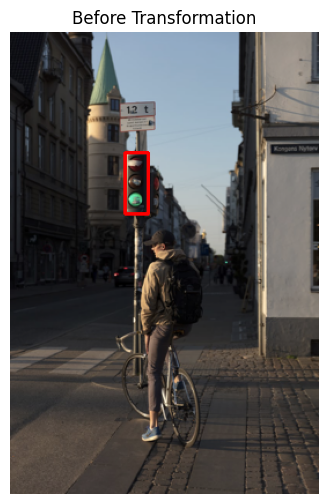

In [ ]:
# before transformation

# Construct the full image path using the base image directory and filename
image_path = os.path.join(img_path, df_train['filename'].iloc[100])

# Read the image using the correct path
im = cv2.imread(image_path)

if im is None:
    print(f"Image could not be read from: {image_path}. Check the file format and path.")
else:
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Extract the bounding box coordinates as a list or NumPy array
    # The columns are 'xmin', 'ymin', 'xmax', 'ymax' in that order
    bbox = df_train.loc[100, ['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    show_corner_bb(im, bbox)

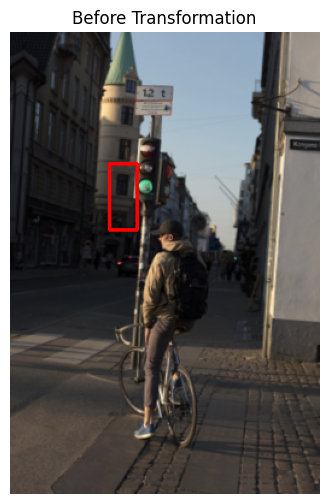

In [ ]:
# after transformation

# Get the row for index 100 using .loc for clarity and robustness
row_data = df_train.loc[100]

# Construct the full image path using the base image directory and filename
# Make sure img_path is correctly defined
image_path = os.path.join(img_path, row_data['filename'])

# Extract the bounding box coordinates as a NumPy array from the correct columns
# transformsXY expects bb as a NumPy array
bbox = row_data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Call transformsXY with the correct image path and bounding box
# Ensure the path is a string as transformsXY expects
im, bb = transformsXY(str(image_path), bbox, True)

# Show the transformed image and bounding box
show_corner_bb(im, bb)

# Split DataSet

In [ ]:
# Add this block of code to process the images and bounding boxes
# You need to define the write_path for the resized images
resized_img_dir = Path('./images_resized') # Define the directory to save resized images
resized_img_dir.mkdir(exist_ok=True) # Create the directory if it doesn't exist

# Iterate through the DataFrame and apply the resizing and bounding box update
# Store the results in new columns 'new_path' and 'new_bb'
new_data = []
for index, row in df_train.iterrows():
    # Use the full path to the original image and the original bounding box
    original_image_path = os.path.join(img_path, row['filename'])
    original_bbox = row[['xmin', 'ymin', 'xmax', 'ymax']].values
    # Call the resize function with the original path, write path, original bbox, and desired size (sz=300 is a common size)
    new_path, new_bb = resize_image_bb(Path(original_image_path), resized_img_dir, original_bbox, sz=300)
    new_data.append({'new_path': new_path, 'new_bb': new_bb})

# Create a new DataFrame from the processed data
new_data_df = pd.DataFrame(new_data)

# Concatenate the new columns to the original df_train DataFrame
df_train = pd.concat([df_train, new_data_df], axis=1)

# Now, the df_train DataFrame should have 'new_path' and 'new_bb' columns

df_train = df_train.reset_index(drop=True) # reset_index again after adding columns

X = df_train[['new_path', 'new_bb']]
y = df_train['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

# Road Traffic Signs Dataset

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values

    def normalize(self, im):
        imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
        return (im - imagenet_stats[0])/imagenet_stats[1]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = self.normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [ ]:
batch_size = 64

train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_test['new_path'],X_test['new_bb'],y_test)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Bounding Box Model

In [ ]:
class BB(nn.Module):
    def __init__(self):
        super(BB, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

# Training

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        if (i+1) % 10 == 0:
            print("i:%4d train_loss:%5.3f val_loss:%5.3f val_acc:%5.3f" % ((i+1), train_loss, val_loss, val_acc))
    return sum_loss/total

In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [ ]:
model = BB().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.002)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Check if CUDA is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the selected device
model = BB().to(device)

parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.002)

# Modify the data loading loops to move tensors to the selected device
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            # Move tensors to the selected device
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        if (i+1) % 10 == 0:
            print("i:%4d train_loss:%5.3f val_loss:%5.3f val_acc:%5.3f" % ((i+1), train_loss, val_loss, val_acc))
    return sum_loss/total

def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    with torch.no_grad(): # Use torch.no_grad() for validation to save memory and speed
        for x, y_class, y_bb in valid_dl:
            batch = y_class.shape[0]
            # Move tensors to the selected device
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            _, pred = torch.max(out_class, 1)
            correct += pred.eq(y_class).sum().item()
            sum_loss += loss.item()
            total += batch
    return sum_loss/total, correct/total

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_epocs(model, optimizer, train_dl, valid_dl, epochs=20, criterion=None, device='cuda'):
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_dl):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(valid_dl):.4f}, Accuracy: {val_accuracy:.2f}%")


# Prediction

In [ ]:
# Predict the first image of the validation set
test_batch = next(iter(valid_dl))

# Move the batch to the selected device (CPU or GPU)
# The type conversion to float() is still needed for the model input
test_batch = [t.to(device).float() if torch.is_floating_point(t) else t.to(device) for t in test_batch]

# Unpack the moved tensors
x_test, y_class_test, y_bb_test = test_batch

# Now you can use x_test, y_class_test, and y_bb_test with your model
# For example, to get model predictions:
# with torch.no_grad():
#     out_class_test, out_bb_test = model(x_test)

In [ ]:
out, bb = model(test_batch[0])

In [ ]:
out

tensor([[  1.7644,  -0.5785,  -0.9453,  -0.9049],
        [  2.0608,  -0.4248,  -0.8714,  -1.1624],
        [  1.3073,  -0.5598,  -0.9577,  -0.8250],
        [  1.5187,  -0.3661,  -0.7586,  -0.7585],
        [  1.1541,  -0.3402,  -0.7793,  -0.7712],
        [  1.0346,  -0.4589,  -0.8127,  -0.6151],
        [  0.8054,  -0.3009,  -0.6997,  -0.3706],
        [  1.3549,  -0.4638,  -0.8936,  -0.7638],
        [  0.9526,  -0.3351,  -0.7190,  -0.5816],
        [  1.1632,  -0.3915,  -0.7025,  -0.3456],
        [  1.8929,  -0.1869,  -0.5606,  -0.5284],
        [  1.3297,  -0.4488,  -0.8731,  -0.8183],
        [-11.0889,   2.5514,   8.2589,   2.3211],
        [  1.8636,  -0.1021,  -0.4979,  -0.5130],
        [  0.9687,  -0.3560,  -0.7403,  -0.6690],
        [  0.8671,  -0.4092,  -0.8098,  -0.2471],
        [  1.2636,  -0.4408,  -0.8629,  -0.5867],
        [ -7.4688,   1.7349,   6.1312,   2.0519],
        [  1.5952,  -0.5353,  -0.9946,  -1.1522],
        [  1.0367,  -0.3498,  -0.7601,  -0.4732],


In [ ]:
print('Class :', idx_to_class[torch.argmax(out[0]).item()])

Class : speedlimit


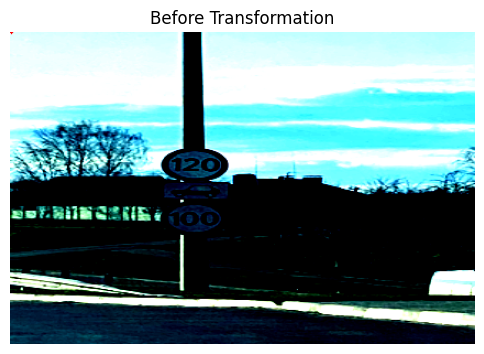

In [ ]:
show_corner_bb(np.moveaxis(test_batch[0][0].cpu().numpy(), 0, 2), bb.detach().cpu().numpy().astype(int)[0])